In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#seeding for comparing experiment in part 2
import torch
import json
SEED = 2015
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device('cuda:6')

# SNLI Bert
## Second Tutorial
https://towardsdatascience.com/fine-tuning-pre-trained-transformer-models-for-sentence-entailment-d87caf9ec9db
Check his Github code for complete notebook. I never referred to it. Medium was enough.
BERT in keras-tf: https://towardsdatascience.com/bert-in-keras-with-tensorflow-hub-76bcbc9417b

In [3]:
# define macros
BERT_MODEL = 'bert-base-german-cased'
batch_size = 4
batches_per_epoch = 125

save_path_suffix = 'finetuning_baseline_de_en_de_labelset_enlargebatch_500_'
#copy4

# Prepare data

## load the dataset

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd

# custom reader needed to handle quotechars
def read_df_custom(file):
    header = 'doc     unit1_toks      unit2_toks      unit1_txt       unit2_txt       s1_toks s2_toks unit1_sent      unit2_sent      dir     nuc_children    sat_children    genre   u1_discontinuous        u2_discontinuous       u1_issent        u2_issent       u1_length       u2_length       length_ratio    u1_speaker      u2_speaker      same_speaker    u1_func u1_pos  u1_depdir       u2_func u2_pos  u2_depdir       doclen  u1_position      u2_position     percent_distance        distance        lex_overlap_words       lex_overlap_length      unit1_case      unit2_case      label'
    extracted_columns = ['unit1_txt', 'unit1_sent', 'unit2_txt', 'unit2_sent', 'dir', 'label', 'distance', 'u1_depdir', 'u2_depdir', 'u2_func', 'u1_position', 'u2_position', 'sat_children', 'nuc_children', 'genre', 'unit1_case', 'unit2_case',
                            'u1_discontinuous', 'u2_discontinuous', 'same_speaker', 'lex_overlap_length', 'u1_func']
    header = header.split()
    df = pd.DataFrame(columns=extracted_columns)
    file = open(file, 'r')

    rows = []
    count = 0 
    for line in file:
        line = line[:-1].split('\t')
        count+=1
        if count ==1: continue
        row = {}
        for column in extracted_columns:
            index = header.index(column)
            try:
                row[column] = line[index]
            except:
                print(count, line)
            row[column] = line[index]
        rows.append(row)

    df = pd.concat([df, pd.DataFrame.from_records(rows)])
    return df

train_df_en = read_df_custom('../../processed/translated/eng.rst.rstdt_train_enriched_translated.rels')
test_df_en = read_df_custom('../../processed/translated/eng.rst.rstdt_test_enriched_translated.rels')
val_df_en = read_df_custom('../../processed/translated/eng.rst.rstdt_dev_enriched_translated.rels')
train_df_de = read_df_custom('../../processed/deu.rst.pcc_train_enriched.rels')
test_df_de = read_df_custom('../../processed/deu.rst.pcc_test_enriched.rels')
val_df_de = read_df_custom('../../processed/deu.rst.pcc_dev_enriched.rels')

lang='deu'

In [5]:
def process_labels_and_merge_evaluation_for_german(df):
    for delete_label in ['attribution', 'comparison', 'explanation', 'enablement', 'temporal', 'textual-organization', 'topic-change', 'topic-comment']:
        df = df[df.label != delete_label]
    df['label'] = df['label'].str.replace("manner-means", "means")
    df['label'] = df['label'].str.replace("evaluation-n", "evaluation")
    df['label'] = df['label'].str.replace("evaluation-s", "evaluation")
    return df

train_df_de = process_labels_and_merge_evaluation_for_german(train_df_de)
test_df_de = process_labels_and_merge_evaluation_for_german(test_df_de)
val_df_de = process_labels_and_merge_evaluation_for_german(val_df_de)

train_df_en = process_labels_and_merge_evaluation_for_german(train_df_en)
test_df_en = process_labels_and_merge_evaluation_for_german(test_df_en)
val_df_en = process_labels_and_merge_evaluation_for_german(val_df_en)

In [6]:
print(len(train_df_en))
train_df_en = train_df_en.sample(n=500, random_state=SEED)
print(len(train_df_en))

11430
500


## Prepare a dataset handler class

In [7]:
train_df_de.head()

,unit1_txt,unit1_sent,unit2_txt,unit2_sent,dir,label,distance,u1_depdir,u2_depdir,u2_func,...,sat_children,nuc_children,genre,unit1_case,unit2_case,u1_discontinuous,u2_discontinuous,same_speaker,lex_overlap_length,u1_func
0,Dagmar Ziegler sitzt in der Schuldenfalle .,Dagmar Ziegler sitzt in der Schuldenfalle .,hat sie jetzt eine seit mehr als einem Jahr er...,Auf Grund der dramatischen Kassenlage in Brand...,1>2,interpretation,2,ROOT,ROOT,root,...,0,4,news,cap_initial,other,False,False,True,0,root
1,Auf Grund der dramatischen Kassenlage in Brand...,Auf Grund der dramatischen Kassenlage in Brand...,hat sie jetzt eine seit mehr als einem Jahr er...,Auf Grund der dramatischen Kassenlage in Brand...,1>2,cause,1,RIGHT,ROOT,root,...,0,4,news,cap_initial,other,False,False,True,0,obl
2,hat sie jetzt eine seit mehr als einem Jahr er...,Auf Grund der dramatischen Kassenlage in Brand...,Der Rückzieher der Finanzministerin ist aber v...,Der Rückzieher der Finanzministerin ist aber v...,1>2,evaluation,4,ROOT,ROOT,root,...,4,3,news,other,cap_initial,False,False,True,0,root
3,hat sie jetzt eine seit mehr als einem Jahr er...,Auf Grund der dramatischen Kassenlage in Brand...,"und vorgeschlagen , erst 2003 darüber zu entsc...",Auf Grund der dramatischen Kassenlage in Brand...,1<2,conjunction,1,ROOT,LEFT,conj,...,0,4,news,other,other,False,False,True,0,root
4,hat sie jetzt eine seit mehr als einem Jahr er...,Auf Grund der dramatischen Kassenlage in Brand...,"Überraschend ,","Überraschend , weil das Finanz- und das Bildun...",1<2,interpretation,2,ROOT,ROOT,root,...,1,4,news,other,title,False,False,True,0,root


In [8]:
train_df_de.columns

Index(['unit1_txt', 'unit1_sent', 'unit2_txt', 'unit2_sent', 'dir', 'label',
       'distance', 'u1_depdir', 'u2_depdir', 'u2_func', 'u1_position',
       'u2_position', 'sat_children', 'nuc_children', 'genre', 'unit1_case',
       'unit2_case', 'u1_discontinuous', 'u2_discontinuous', 'same_speaker',
       'lex_overlap_length', 'u1_func'],
      dtype='object')

# feats

In [9]:
from multiprocessing.sharedctypes import Value
import torch
from torch.utils.data import Dataset, TensorDataset, DataLoader, ConcatDataset
from sys import path
path.append('/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/allennlp/data/data_loaders/')
from allennlp.data import allennlp_collate, Vocabulary
from features_custom_original import get_vocab_feature_name
from torch.nn.utils.rnn import pad_sequence
from transformers import BertTokenizer, BertTokenizer
from collections import Counter

class MNLIDataBert(Dataset):

  def __init__(self, train_df, val_df, test_df, aux_label_dict={}):
    self.lang = lang
    self.num_labels = set()
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    self.tokenizer = BertTokenizer.from_pretrained(BERT_MODEL, do_lower_case=True) # Using a pre-trained BERT tokenizer to encode sentences
    self.train_data = None
    self.val_data = None
    self.test_data = None
    self.train_idx = None
    self.val_idx = None
    self.test_idx = None
    self.vocab = Vocabulary(counter=None, max_vocab_size=100000)
    self.init_data(aux_label_dict)

  def init_data(self, aux_label_dict):
    self.get_label_mapping(aux_label_dict)
    self.init_feature_list()
    self.init_feature_mappings_and_bins()
    self.apply_bins()
    self.calculate_unique_values()
    self.train_data, self.train_idx = self.load_data(self.train_df)
    self.val_data, self.val_idx = self.load_data(self.val_df)
    self.test_data, self.test_idx = self.load_data(self.test_df)
    

  def combine_unique_column_values_to_dict(self, column_name):
    ini_set = set([*self.train_df[column_name].unique(), *self.val_df[column_name].unique()])
    res = dict.fromkeys(ini_set, 0)
    return res

  def get_label_mapping(self, aux_label_dict):
    labels = aux_label_dict
    shift_count = len(labels)
    labels_list = list(set(list(self.train_df['label'].unique()) + list(self.test_df['label'].unique()) + list(self.val_df['label'].unique())))
    count=0
    for i in range(len(labels_list)):
      if labels_list[i] not in labels:
        labels[labels_list[i]] = shift_count+count
        count+=1
    self.label_dict = labels
    # needed later for classification report object to generate precision and recall on test dataset
    self.rev_label_dict = {self.label_dict[k]:k for k in self.label_dict.keys()} 
    if aux_label_dict: print(len(self.label_dict), len(aux_label_dict), len(labels_list))
    else: print(len(self.label_dict), len(labels_list))

  def init_feature_mappings_and_bins(self):
    self.feature_maps = { 'genre': self.combine_unique_column_values_to_dict('genre'),
                          'unit1_case': self.combine_unique_column_values_to_dict('unit1_case'),
                          'unit2_case': self.combine_unique_column_values_to_dict('unit2_case'),
                          'u1_func': self.combine_unique_column_values_to_dict('u1_func'),
                          'u2_func': self.combine_unique_column_values_to_dict('u2_func') }

    self.bins = {
      'distance': [[-1e9, -8], [-8, -2], [-2, 0], [0, 2], [2, 8], [8, 1e9]],
      'u1_position': [[0.0, 0.1], [0.1, 0.2], [0.2, 0.3], [0.3, 0.4], [0.4, 0.5], [0.5, 0.6], [0.6, 0.7], [0.7, 0.8], [0.8, 0.9], [0.9, 1.0], [1.0, 1e9]],
      'u2_position': [[0.0, 0.1], [0.1, 0.2], [0.2, 0.3], [0.3, 0.4], [0.4, 0.5], [0.5, 0.6], [0.6, 0.7], [0.7, 0.8], [0.8, 0.9], [0.9, 1.0], [1.0, 1e9]],
      'lex_overlap_length': [[0, 2], [2, 7], [7, 1e9]]
    }   

  def add_directionality(self, premise, hypothesis, dir):
    if dir == "1<2":
        hypothesis = '< ' + hypothesis + ' {'
    else:
        premise = '} ' + premise + ' >'
    return premise, hypothesis

  def init_feature_list(self):
    if self.lang=='nld':
      self.feature_list = ['distance', 'u1_depdir', 'sat_children', 'genre', 'u1_position']
    elif self.lang=='deu':
      self.feature_list = ['distance', 'u1_depdir', 'u2_depdir', 'u2_func', 'u1_position', 'u2_position', 'sat_children', 'nuc_children']
    elif self.lang=='eng.rst.gum':
      self.feature_list = ['distance', 'same_speaker', 'u2_func', 'u2_depdir', 'unit1_case', 'unit2_case', 'nuc_children',
                      'sat_children', 'genre', 'lex_overlap_length', 'u2_discontinuous', 'u1_discontinuous', 'u1_position', 'u2_position']
    elif self.lang=='fas':
      self.feature_list = ['distance', 'nuc_children', 'sat_children', 'u2_discontinuous', 'genre']
    elif self.lang=='spa.rst.sctb':
      self.feature_list = ['distance', 'u1_position', 'sat_children']
    elif self.lang=='zho.rst.sctb':
      self.feature_list = ['sat_children', 'nuc_children', 'genre', 'u2_discontinuous', 'u1_discontinuous', 'u1_depdir', 'u1_func']
    else: 
      raise ValueError()

  def get_mapping_from_dictionary(self, column_name, dict_val):
    return self.feature_maps[column_name][dict_val]

  def get_allen_features_list(self, features, feature_name):
    if feature_name in ['distance', 'u1_depdir', 'u2_depdir', 'u1_func', 'u2_func', 
    'u1_position', 'u2_position', 'genre', 'same_speaker', 'unit1_case', 'unit2_case',
    'lex_overlap_length', 'u2_discontinuous', 'u1_discontinuous', 'dir']: feature_value = self.apply_vocab(features[feature_name], feature_name) #for categorical values
    elif feature_name in ['sat_children', 'nuc_children']: feature_value = float(features[feature_name]) #for identiy values
    else: 
      print(feature_name)
      raise ValueError()
    return feature_value

  def transform_feature(self, features):
    assert len(features)==17
    #after applying the vocab. we need to pass them as int
    return {feature_name: torch.tensor(int(self.get_allen_features_list(features, feature_name))).to(device) for feature_name in self.feature_list+['dir']}

  def calculate_unique_values(self):
    for feature_name in self.feature_list+['dir']:
      vocab_feature_name = get_vocab_feature_name(feature_name)
      self.vocab.add_tokens_to_namespace(self.train_df[feature_name].apply(lambda x: str(x)), namespace=vocab_feature_name)
      self.vocab.add_tokens_to_namespace(self.val_df[feature_name].apply(lambda x: str(x)), namespace=vocab_feature_name)

  def apply_bins(self):
    for df in [self.train_df, self.test_df, self.val_df]:
      for feature_name in self.bins.keys():
        if feature_name=='u2_func':
          print(df[feature_name].unique())
          raise ValueError()
        df[feature_name] = df[feature_name].apply(lambda x: self.get_mapping_from_bin(feature_name, float(x)))

  def get_mapping_from_bin(self, column_name, dict_val):
    bins = self.bins[column_name]
    for b,i in zip(bins, range(len(bins))):
      left = b[0]
      right = b[1]
      if left<=dict_val and right>=dict_val: return i

  def apply_vocab(self, feature_value, feature_name):
    return self.vocab.get_token_index(str(feature_value), namespace=get_vocab_feature_name(feature_name))

  def set_labels(self):
    self.num_labels = len(self.num_labels)
    
  def load_data(self, df):
    MAX_LEN = 512 
    token_ids = []
    mask_ids = []
    # seg_ids = []
    y = []
    feats = []
    idx = []
    idx_map = {}

    self.num_labels.update(df['label'].unique())

    count=0
    for row in df.iterrows():
      row = row[1]
      premise = row['unit1_txt']
      hypothesis = row['unit2_txt']
      label = row['label']
      dir = row['dir']

      features = {'distance': row['distance'],
                'u1_depdir': row['u1_depdir'],
                'u2_depdir': row['u2_depdir'],
                'u1_func': row['u1_func'],
                'u2_func': row['u2_func'],
                'u1_position': row['u1_position'],
                'u2_position': row['u2_position'],
                'sat_children': row['sat_children'],
                'nuc_children': row['nuc_children'],
                'genre': row['genre'],
                'unit1_case': row['unit1_case'],
                'unit2_case': row['unit2_case'],
                'u1_discontinuous': row['u1_discontinuous'],
                'u2_discontinuous': row['u2_discontinuous'],
                'same_speaker': row['same_speaker'],
                'lex_overlap_length': row['lex_overlap_length'],
                'dir': row['dir']}

      premise, hypothesis = self.add_directionality(premise, hypothesis, dir)
      encoded = self.tokenizer.encode_plus(premise, hypothesis, add_special_tokens = True, max_length=MAX_LEN, truncation=True, padding=False) #padding='max_length'
      pair_token_ids = torch.tensor(encoded['input_ids'])

      # segment_ids = torch.tensor(encoded['token_type_ids'])
      attention_mask_ids = torch.tensor(encoded['attention_mask'])
      assert len(pair_token_ids)==len(attention_mask_ids)

      features = self.transform_feature(features)

      token_ids.append(pair_token_ids)
      # seg_ids.append(segment_ids)
      mask_ids.append(attention_mask_ids)
      y.append(self.label_dict[label])
      feats.append(features)
      
      idx_map[count] = [premise, hypothesis]
      idx.append(count)
      count+=1
      
    token_ids = pad_sequence(token_ids, batch_first=True)
    mask_ids = pad_sequence(mask_ids, batch_first=True)
    # seg_ids = pad_sequence(seg_ids, batch_first=True)
    y = torch.tensor(y)
    idx = torch.tensor(idx)

    class featureDataset(Dataset):
      def __init__(self, token_ids, mask_ids, feats, y, idx):
          self.token_ids = token_ids
          self.mask_ids = mask_ids
          # self.seg_ids = seg_ids
          self.feats = feats
          self.y = y
          self.idx = idx

      def __len__(self):
          return len(self.feats)

      def __getitem__(self, idx):
          return self.token_ids[idx], self.mask_ids[idx], self.feats[idx], self.y[idx], self.idx[idx]
          # return self.token_ids[idx], self.mask_ids[idx], self.seg_ids[idx], self.feats[idx], self.y[idx], self.idx[idx]

    # dataset = featureDataset(token_ids, mask_ids, seg_ids, feats, y, idx)
    dataset = featureDataset(token_ids, mask_ids, feats, y, idx)
    return dataset, idx_map

  def get_data_loaders(self, batch_size=4, batches_per_epoch=402, shuffle=True): #1609 samples / 64:25=1600 / 402:4=1608
    self.set_labels()
    train_loader_torch = DataLoader(
      self.train_data,
      shuffle=shuffle,
      batch_size=batch_size,
    )

    val_loader_torch = DataLoader(
      self.val_data,
      shuffle=shuffle,
      batch_size=batch_size,
    )

    test_loader_torch = DataLoader(
      self.test_data,
      shuffle=False,
      batch_size=batch_size,
    )
    
    train_loader = LoaderWrapper(train_loader_torch, n_step=batches_per_epoch)
    val_loader = LoaderWrapper(val_loader_torch, n_step=batches_per_epoch)
    test_loader = LoaderWrapper(test_loader_torch, n_step=batches_per_epoch)

    return train_loader, val_loader_torch, test_loader_torch

2023-02-03 14:26:04.145252: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-03 14:26:04.405074: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda-10.1/lib64:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda-10.2/targets/x86_64-linux/lib/:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-03 14:26:04.405097: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-03

In [10]:
class LoaderWrapper:
    def __init__(self, loader, n_step):
        self.step = n_step
        self.idx = 0
        self.iter_loader = iter(loader)
        self.loader = loader
    
    def __iter__(self):
        return self

    def __len__(self):
        return self.step

    def __next__(self):
        # if reached number of steps desired, stop
        if self.idx == self.step:
            self.idx = 0
            raise StopIteration
        else:
            self.idx += 1
        # while True
        try:
            return next(self.iter_loader)
        except StopIteration:
            # reinstate iter_loader, then continue
            self.iter_loader = iter(self.loader)
            return next(self.iter_loader)

### Mnliloader

In [11]:
mnli_dataset_en = MNLIDataBert(train_df_en, val_df_en, test_df_en)

train_loader_en, val_loader_en, test_loader_en = mnli_dataset_en.get_data_loaders(batch_size=batch_size, batches_per_epoch=batches_per_epoch)
label_dict_en = mnli_dataset_en.label_dict # required by custom func to calculate accuracy, bert model
rev_label_dict_en = mnli_dataset_en.rev_label_dict # required by custom func to calculate accuracy

9 9 9


In [12]:
mnli_dataset_de = MNLIDataBert(train_df_de, val_df_de, test_df_de, mnli_dataset_en.label_dict) #join the labels sets of de and en for prediction

train_loader_de, val_loader_de, test_loader_de = mnli_dataset_de.get_data_loaders(batch_size=541, batches_per_epoch=batches_per_epoch)
label_dict_de = mnli_dataset_de.label_dict # required by custom func to calculate accuracy, bert model
rev_label_dict_de = mnli_dataset_de.rev_label_dict # required by custom func to calculate accuracy
mnli_dataset_de.num_labels = len(label_dict_de)

25 25 25


In [13]:
for feature in mnli_dataset_en.feature_list:
    vocab_feature_name = get_vocab_feature_name(feature)
    mnli_dataset_en.vocab.add_tokens_to_namespace(train_df_de[feature].apply(lambda x: str(x)), namespace=vocab_feature_name)
    mnli_dataset_en.vocab.add_tokens_to_namespace(val_df_de[feature].apply(lambda x: str(x)), namespace=vocab_feature_name)
    print('en: ', feature, ': ', len(mnli_dataset_en.vocab.get_token_to_index_vocabulary(vocab_feature_name)), ':', mnli_dataset_en.vocab.get_token_to_index_vocabulary(vocab_feature_name))
    
    mnli_dataset_de.vocab.add_tokens_to_namespace(train_df_en[feature].apply(lambda x: str(x)), namespace=vocab_feature_name)
    mnli_dataset_de.vocab.add_tokens_to_namespace(val_df_en[feature].apply(lambda x: str(x)), namespace=vocab_feature_name)
    print('de: ', feature, ': ', len(mnli_dataset_de.vocab.get_token_to_index_vocabulary(vocab_feature_name)), ':', mnli_dataset_de.vocab.get_token_to_index_vocabulary(vocab_feature_name))
print('dir', ': ', mnli_dataset_en.vocab.get_token_to_index_vocabulary('dir'))


en:  distance :  5 : {'@@PADDING@@': 0, '@@UNKNOWN@@': 1, '4': 2, '3': 3, '5': 4}
de:  distance :  5 : {'@@PADDING@@': 0, '@@UNKNOWN@@': 1, '3': 2, '4': 3, '5': 4}
en:  u1_depdir :  5 : {'@@PADDING@@': 0, '@@UNKNOWN@@': 1, 'ROOT': 2, 'LEFT': 3, 'RIGHT': 4}
de:  u1_depdir :  5 : {'@@PADDING@@': 0, '@@UNKNOWN@@': 1, 'ROOT': 2, 'RIGHT': 3, 'LEFT': 4}
en:  u2_depdir :  5 : {'@@PADDING@@': 0, '@@UNKNOWN@@': 1, 'ROOT': 2, 'LEFT': 3, 'RIGHT': 4}
de:  u2_depdir :  5 : {'@@PADDING@@': 0, '@@UNKNOWN@@': 1, 'ROOT': 2, 'RIGHT': 3, 'LEFT': 4}
en:  u2_func :  31 : {'@@PADDING@@': 0, '@@UNKNOWN@@': 1, 'root': 2, 'dep': 3, 'advcl': 4, 'obl': 5, 'conj': 6, 'acl:relcl': 7, 'punct': 8, 'acl': 9, 'amod': 10, 'ccomp': 11, 'obj': 12, 'cc': 13, 'nmod': 14, 'nsubj': 15, 'flat': 16, 'appos': 17, 'parataxis': 18, 'xcomp': 19, 'compound': 20, 'discourse': 21, 'advmod': 22, 'nummod': 23, 'nsubj:pass': 24, 'nmod:poss': 25, 'case': 26, 'csubj': 27, 'aux': 28, 'iobj': 29, 'csubj:pass': 30}
de:  u2_func :  31 : {'@@P

In [14]:
for batch_idx, (pair_token_ids, mask_ids, feat, y, idx) in enumerate(train_loader_en):
    assert len(feat)==len(mnli_dataset_en.feature_list)+1

# Define the model

## load pretrained model

In [15]:
from transformers import BertForSequenceClassification, AdamW
from torch import optim
import os
path.append(os.path.join(os.getcwd(), '../utils/'))
from CategoricalAccuracy import CategoricalAccuracy as CA
import numpy as np

ca = CA()

x = torch.tensor(np.array([[[1,0,0], [1,0,0], [1,0,0]]]))
y1 = torch.tensor(np.array([[0], [1], [1]]))
y2 = torch.tensor(np.array([[0], [0], [0]]))

ca(x,y1)
print(ca.get_metric(reset=True))
ca(x,y2)
print(ca.get_metric(reset=True))

0.3333333333333333
1.0


## define evaulation metric

In [16]:
# to evaluate model for train and test. And also use classification report for testing
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

# helper function to calculate the batch accuracy
def multi_acc(y_pred, y_test, allennlp=False):
  if allennlp==False:
    acc = (torch.log_softmax(y_pred, dim=1).argmax(dim=1) == y_test).sum().float() / float(y_test.size(0))
    return acc

# freeze model weights and measure validation / test 
def evaluate_accuracy(model, optimizer, data_loader, rev_label_dict, label_dict, is_training=True):
  model.eval()
  total_val_acc  = 0
  total_val_loss = 0
  
  #for classification report
  y_true = []
  y_pred = []
  idx_list = []
  premise_list = []
  hypo_list = []
  idx_map = mnli_dataset_en.val_idx if is_training else mnli_dataset_en.test_idx

  with torch.no_grad():
    for batch_idx, (pair_token_ids, mask_ids, feat, y, idx) in enumerate(data_loader):      
      optimizer.zero_grad()
      pair_token_ids = pair_token_ids.to(device)
      mask_ids = mask_ids.to(device)
      # seg_ids = seg_ids.to(device)
      labels = y.to(device)
      # feat = feat.to(device)
      
      outputs = model(pair_token_ids, 
                            # token_type_ids=seg_ids, 
                            attention_mask=mask_ids, 
                            feat=feat)
      criterion = nn.CrossEntropyLoss()
      loss = criterion(outputs, labels)
      acc = multi_acc(outputs, labels)

      total_val_loss += loss.item()
      total_val_acc  += acc.item()

      # log predictions for classification report
      argmax_predictions = torch.argmax(outputs,dim=1).tolist()
      labels_list = labels.tolist()
      assert(len(labels_list)==len(argmax_predictions))
      for p in argmax_predictions: y_pred.append(rev_label_dict[int(p)])
      for l in labels_list: y_true.append(rev_label_dict[l])
      for i in idx.tolist():
        idx_list.append(i)
        premise_list.append(idx_map[i][0])
        hypo_list.append(idx_map[i][1])

  val_acc  = total_val_acc/len(data_loader)
  val_loss = total_val_loss/len(data_loader)
  cr = classification_report(y_true, y_pred)

  idx_json = {'idx': idx_list, 'gold_label': y_true, 'pred_label': y_pred, 'premise': premise_list, 'hypothesis': hypo_list}
  
  return val_acc, val_loss, cr, model, optimizer

## define custom bert model

In [17]:
import copy
from typing import Any, Dict, Optional
from transformers import BertModel, BertConfig
import torch.nn as nn
from tensorflow.keras.layers import TimeDistributed
from featurefulbertembedder_custom_allennlp_dims import FeaturefulBertEmbedder
from featureful_bert_custom_allennlp_dims import get_combined_feature_tensor_2 as get_combined_feature_tensor_forward
from features_custom_allennlp_dims import get_feature_modules

class CustomPooler2(nn.Module):
    def __init__(self, *,
                        requires_grad: bool = True,
                        dropout: float = 0.0,
                        transformer_kwargs: Optional[Dict[str, Any]] = None, ) -> None:
        super().__init__()
        bert = BertModel.from_pretrained(BERT_MODEL) #only used to pass config. BertAttentionClass used in FeatureFulBert
        self._dropout = torch.nn.Dropout(p=dropout)
        self.pooler = copy.deepcopy(bert.pooler)
        for param in self.pooler.parameters():
            param.requires_grad = requires_grad
        self._embedding_dim = bert.config.hidden_size

    def get_input_dim(self) -> int:
        return self._embedding_dim

    def get_output_dim(self) -> int:
        return self._embedding_dim

    def forward(self, tokens: torch.Tensor, mask: torch.BoolTensor = None, num_wrapping_dims: int = 0):
        pooler = self.pooler
        
        for _ in range(num_wrapping_dims):
            pooler = TimeDistributed(pooler)
        pooled = pooler(tokens)
        pooled = self._dropout(pooled)
        return pooled

class MyModule(nn.Module):    
    def __init__(self, feature_list):
        super(MyModule, self).__init__()
        self.feature_list = feature_list
        self.feature_modules = nn.ModuleDict()
        self.dims = 0
        self.feature_modules, dims = get_feature_modules(feature_list, mnli_dataset_de.vocab, use_allennlp_dims=True)
        self.dims += dims

        print(self.feature_modules)
        for feature in feature_list:
            if feature not in ['distance', 'u1_depdir', 'u2_depdir', 'u2_func', 'u1_position', 'u2_position', 
                                'nuc_children', 'sat_children']: raise ValueError()
            # elif 'genre' in feature_list:               self.modules['genre'] = nn.Embedding(mnli_dataset_en.distance_unique, 3)
            # elif 'unit1_case' in feature_list:          self.modules['unit1_case'] = nn.Embedding(mnli_dataset_en.distance_unique, 3)
            # elif 'unit2_case' in feature_list:          self.modules['unit2_case'] = nn.Embedding(mnli_dataset_en.distance_unique, 3)
            # elif 'u1_discontinuous' in feature_list:    self.modules['u1_discontinuous'] = nn.Embedding(mnli_dataset_en.distance_unique, 3)
            # elif 'u2_discontinuous' in feature_list:    self.modules['u2_discontinuous'] = nn.Embedding(mnli_dataset_en.distance_unique, 3)
            # elif 'same_speaker' in feature_list:        self.modules['same_speaker'] = nn.Embedding(mnli_dataset_en.distance_unique, 3)
            # elif 'lex_overlap_length' in feature_list:  self.modules['lex_overlap_length'] = nn.Embedding(mnli_dataset_en.distance_unique, 3)
            # elif 'u1_func' in feature_list:             self.modules['u1_func'] = nn.Embedding(mnli_dataset_en.distance_unique, 3)
            

    def forward(self, features):
        feature_list = ['distance', 'u1_depdir', 'u2_depdir', 'u2_func', 'u1_position', 'u2_position', 'sat_children', 'nuc_children']
        for i in range(len(feature_list)):
            feature_name = feature_list[i]
            feature_modules = self.feature_modules[feature_name]
            feature = features[...,i]
            if feature_name not in ['sat_children', 'nuc_children']:
                if torch.max(feature)>feature_modules.num_embeddings:
                    print(feature_name, feature)
                    raise ValueError()

        return get_combined_feature_tensor_forward(features, self.feature_list, self.feature_modules)

class CustomBERTModel(nn.Module):
    def __init__(self, num_labels):
          super(CustomBERTModel, self).__init__()
          self.num_classes = num_labels
          self.feature_list = mnli_dataset_de.feature_list
          print('ASSIGN:', self.num_classes)

          self.embedder = self.create_featureful_bert() #BERT MODEL
          self.encoder = CustomPooler2()
          self.module1 = MyModule(self.feature_list)
          self.dropout1 = nn.Dropout(p=0.0)
        #   self.dropout_decoder = nn.Dropout(p=0.5)
          self.out_features = self.encoder.pooler.dense.out_features+self.module1.dims
          self.relation_decoder = nn.Linear(self.out_features, self.num_classes)

    def forward(self, pair_token_ids, attention_mask, feat, freeze=False):
        if freeze:
            for param in self.embedder.transformer_model.encoder.parameters():
                param.requires_grad = False
            for param in self.embedder.transformer_model.pooler.parameters():
                param.requires_grad = False
        direction_tensor = feat['dir'].to(device)
        embedded_sentence = self.embedder(token_ids=pair_token_ids, #featurefulmebedder
                        mask=attention_mask, 
                        # type_ids=token_type_ids,
                        segment_concat_mask = None,
                        direction_tensor = direction_tensor,
                        feature_list = self.feature_list,
                        features = feat)
        # mask = token_type_ids
        bertpooler_output = self.encoder(tokens=embedded_sentence, mask=None)
        feat = self.convert_to_feature_list(feat)
        feat = self.dropout1(feat)
        feat = self.module1(feat)
        try:
            feat_concat = torch.concat((bertpooler_output, feat),-1)
        except:
            print(bertpooler_output.shape, feat.shape)
            raise ValueError()
        if feat_concat.shape[-1]!=self.module1.dims+bertpooler_output.shape[-1]: print(feat_concat.shape, self.module1.dims)
        assert feat_concat.shape[-1] == self.module1.dims+bertpooler_output.shape[-1]
        feat_concat = self.dropout1(feat_concat)
        # feat_concat = self.dropout_decoder(feat_concat)
        linear1_output = self.relation_decoder(feat_concat)
        return linear1_output


    def create_featureful_bert(self):
        featureful_bert = FeaturefulBertEmbedder(model_name = BERT_MODEL,
                                hidden_activation_allen = 'gelu',
                                feature_list = self.feature_list, 
                                vocab=mnli_dataset_de.vocab, 
                                use_allen_dims=True)
        return featureful_bert

    def convert_to_feature_list(self, feat):
        feature_linear = [feat[feature_name] for feature_name in self.feature_list]
        feature_linear = torch.stack(feature_linear, dim=-1)
        return feature_linear

model = CustomBERTModel(mnli_dataset_de.num_labels)
model.to(device)
optimizer = AdamW(model.parameters(), lr=2e-6, correct_bias=False) # original 2e-5
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8, mode='max', patience=35, min_lr=5e-7, verbose=True) #original factor=0.6, min_lr=5e-7

ASSIGN: 25


Some weights of the model checkpoint at bert-base-german-cased were not used when initializing FeaturefulBert: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing FeaturefulBert from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing FeaturefulBert from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertModel: ['cls.predictions.transform.d

ModuleDict(
  (distance): Embedding(5, 3, padding_idx=0)
  (u1_depdir): Embedding(5, 3, padding_idx=0)
  (u2_depdir): Embedding(5, 3, padding_idx=0)
  (u2_func): Embedding(31, 6, padding_idx=0)
  (u1_position): Embedding(12, 4, padding_idx=0)
  (u2_position): Embedding(12, 4, padding_idx=0)
  (sat_children): Identity()
  (nuc_children): Identity()
)


/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## define training regime

### prinintg model

In [18]:
print(model)

CustomBERTModel(
  (embedder): FeaturefulBertEmbedder(
    (transformer_model): FeaturefulBert(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30000, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_featur

In [19]:
from torch.utils.tensorboard import SummaryWriter

def writer_init(save_path_suffix):
    writer_path = 'run1/'+save_path_suffix[:-1]+'/'
    if os.path.isdir(writer_path):
        filelist = [ f for f in os.listdir(writer_path) if 'events.out' in f ]
        print(filelist)
        for f in filelist:
            os.remove(os.path.join(writer_path, f))
    else:
        os.mkdir(writer_path)
    writer = SummaryWriter(log_dir=writer_path)
    return writer

writer = writer_init(save_path_suffix)

['events.out.tfevents.1675434023.57e5cab0c4d9.15487.0']


In [20]:
import time
import traceback
import torch.nn.functional as F

from typing import Optional, Iterable, Dict, Any
from EarlyStopperUtil import MetricTracker
from sklearn.metrics import classification_report

EPOCHS = 100

def train(model, train_loader, val_loader, optimizer, scheduler, rev_label_dict, freeze=False):  
  EarlyStopper = MetricTracker(patience=20, metric_name='+accuracy')
  best_val_acc = 0


  for epoch in range(EPOCHS):
    start = time.time()
    model.train()
    total_train_loss = 0
    total_train_acc  = 0
    
    # logging for scheduler
    losses = []
    accuracies= []

    train_size = 0

    for batch_idx, (pair_token_ids, mask_ids, feat, y, idx) in enumerate(train_loader):
      train_size+=1
      optimizer.zero_grad()
      pair_token_ids = pair_token_ids.to(device)
      mask_ids = mask_ids.to(device)
      # seg_ids = seg_ids.to(device)
      labels = y.to(device)
      # feat = feat.to(device)
      outputs = model(pair_token_ids = pair_token_ids, 
                            # token_type_ids=seg_ids, 
                            attention_mask=mask_ids,
                            feat=feat,
                            freeze=freeze)
      criterion = nn.CrossEntropyLoss()
      loss = criterion(outputs, labels)
      loss.backward()
      acc = multi_acc(outputs, labels)
      optimizer.step()
      total_train_loss += loss.item()
      total_train_acc  += acc.item()

      losses.append(loss)
      accuracies.append(acc)
      
    mean_loss = sum(losses)/len(losses)
    scheduler.step(mean_loss)

    train_acc  = total_train_acc/len(train_loader)
    train_loss = total_train_loss/len(train_loader)

    val_acc, val_loss, cr, model, optimizer = evaluate_accuracy(model, optimizer, val_loader, rev_label_dict_en, label_dict_en, None)
    suffix = '_de' if freeze else ''
    if val_acc>best_val_acc:
      torch.save(model.state_dict(), 'run1/'+save_path_suffix+suffix+'_best.pt')
      best_val_acc = val_acc
      print(f'Epoch {epoch+1}: Best val_acc: {best_val_acc:.4f}')
    if val_acc>=best_val_acc:
      torch.save(model.state_dict(), 'run1/'+save_path_suffix+suffix+'_best_latest.pt')
      best_val_acc = val_acc
      print(f'Epoch {epoch+1}: Best val_acc: {best_val_acc:.4f}')
    EarlyStopper.add_metric(val_acc)
    if EarlyStopper.should_stop_early(): break

    end = time.time()
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)

    print(f'Epoch {epoch+1}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {val_loss:.4f} val_acc: {val_acc:.4f}')
    print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))
    print(f'train_size: {train_size}')

    writer.add_scalar('train_loss', train_loss, epoch)
    writer.add_scalar('train_acc', train_acc, epoch)
    writer.add_scalar('val_loss', val_loss, epoch)
    writer.add_scalar('val_acc', val_acc, epoch)



### train

In [21]:
import warnings
from sklearn.exceptions import DataConversionWarning
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    train(model, train_loader_en, val_loader_en, optimizer, scheduler, rev_label_dict_en)

Epoch 1: Best val_acc: 0.5813
Epoch 1: Best val_acc: 0.5813
Epoch 1: train_loss: 1.7732 train_acc: 0.6000 | val_loss: 1.5682 val_acc: 0.5813
00:00:48.37
train_size: 125
Epoch 2: Best val_acc: 0.5813
Epoch 2: train_loss: 1.4199 train_acc: 0.6180 | val_loss: 1.4960 val_acc: 0.5813
00:00:45.96
train_size: 125
Epoch 3: train_loss: 1.3129 train_acc: 0.6180 | val_loss: 1.4691 val_acc: 0.5804
00:00:45.88
train_size: 125
Epoch 4: Best val_acc: 0.5821
Epoch 4: Best val_acc: 0.5821
Epoch 4: train_loss: 1.1812 train_acc: 0.6260 | val_loss: 1.4504 val_acc: 0.5821
00:00:47.69
train_size: 125
Epoch 5: train_loss: 1.0542 train_acc: 0.6860 | val_loss: 1.4407 val_acc: 0.5804
00:00:45.74
train_size: 125
Epoch 6: Best val_acc: 0.5946
Epoch 6: Best val_acc: 0.5946
Epoch 6: train_loss: 0.9218 train_acc: 0.7360 | val_loss: 1.4592 val_acc: 0.5946
00:00:47.98
train_size: 125
Epoch 7: train_loss: 0.8340 train_acc: 0.7780 | val_loss: 1.4550 val_acc: 0.5884
00:00:45.23
train_size: 125
Epoch 8: train_loss: 0.7100

# test

### latest

In [22]:
def validate(model, test_loader, optimizer, rev_label_dict, label_dict):
  start = time.time()
  test_acc, test_loss, cr, model, optimizer = evaluate_accuracy(model, optimizer, test_loader, rev_label_dict, label_dict, is_training=False)
  end = time.time()
  hours, rem = divmod(end-start, 3600)
  minutes, seconds = divmod(rem, 60)

  print(f'Test_loss: {test_loss:.4f} test_acc: {test_acc:.4f}')
  print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))
  print(cr)

  return test_loss, test_acc

test_loss, test_acc = validate(model, test_loader_en, optimizer, rev_label_dict_en, label_dict_en)
writer.add_scalar('test_loss_latest', test_loss, 1)
writer.add_scalar('test_acc_latest', test_acc, 1)
print(f'Test Loss: {test_loss:.3f} |  Test Acc: {test_acc*100:.2f}%')

/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/transformers/modeling_utils.py:768: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Test_loss: 2.1580 test_acc: 0.5306
00:00:25.12
              precision    recall  f1-score   support

  background       0.26      0.23      0.24       103
       cause       0.15      0.07      0.10        85
   condition       0.00      0.00      0.00        47
    contrast       0.42      0.14      0.21       146
 elaboration       0.65      0.82      0.72       796
  evaluation       0.17      0.07      0.10        81
       joint       0.34      0.49      0.40       230
       means       0.25      0.04      0.06        27
     summary       1.00      0.03      0.06        32

    accuracy                           0.53      1547
   macro avg       0.36      0.21      0.21      1547
weighted avg       0.48      0.53      0.48      1547

Test Loss: 2.158 |  Test Acc: 53.06%


/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

### best earliest

In [23]:
freeze=False
suffix = '_de' if freeze else ''
model.load_state_dict(torch.load('run1/'+save_path_suffix+suffix+'_best.pt'))
test_loss, test_acc = validate(model, test_loader_en, optimizer, rev_label_dict_en, label_dict_en)
writer.add_scalar('test_loss_best_earliest', test_loss, 1)
writer.add_scalar('test_acc_best_earliest', test_acc, 1)
print(f'Latest Test Loss: {test_loss:.3f} |  Latest Test Acc: {test_acc*100:.2f}%')

/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/transformers/modeling_utils.py:768: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Test_loss: 1.6304 test_acc: 0.5448
00:00:25.41
              precision    recall  f1-score   support

  background       0.21      0.12      0.15       103
       cause       0.00      0.00      0.00        85
   condition       0.00      0.00      0.00        47
    contrast       0.32      0.04      0.07       146
 elaboration       0.57      0.97      0.72       796
  evaluation       0.00      0.00      0.00        81
       joint       0.47      0.22      0.30       230
       means       0.00      0.00      0.00        27
     summary       0.00      0.00      0.00        32

    accuracy                           0.54      1547
   macro avg       0.17      0.15      0.14      1547
weighted avg       0.41      0.54      0.43      1547

Latest Test Loss: 1.630 |  Latest Test Acc: 54.48%


/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

### best lastest

In [24]:
freeze=False
suffix = '_de' if freeze else ''
model.load_state_dict(torch.load('run1/'+save_path_suffix+suffix+'_best_latest.pt'))
test_loss, test_acc = validate(model, test_loader_en, optimizer, rev_label_dict_en, label_dict_en)
writer.add_scalar('test_loss_best_latest', test_loss, 1)
writer.add_scalar('test_acc_best_latest', test_acc, 1)
print(f'Best Test Loss: {test_loss:.3f} |  Best Test Acc: {test_acc*100:.2f}%')

/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/transformers/modeling_utils.py:768: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Test_loss: 1.6304 test_acc: 0.5448
00:00:25.25
              precision    recall  f1-score   support

  background       0.21      0.12      0.15       103
       cause       0.00      0.00      0.00        85
   condition       0.00      0.00      0.00        47
    contrast       0.32      0.04      0.07       146
 elaboration       0.57      0.97      0.72       796
  evaluation       0.00      0.00      0.00        81
       joint       0.47      0.22      0.30       230
       means       0.00      0.00      0.00        27
     summary       0.00      0.00      0.00        32

    accuracy                           0.54      1547
   macro avg       0.17      0.15      0.14      1547
weighted avg       0.41      0.54      0.43      1547

Best Test Loss: 1.630 |  Best Test Acc: 54.48%


/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

### best val

In [25]:
freeze=False
suffix = '_de' if freeze else ''
model.load_state_dict(torch.load('run1/'+save_path_suffix+suffix+'_best_latest.pt'))
test_loss, test_acc = validate(model, val_loader_en, optimizer, rev_label_dict_en, label_dict_en)
writer.add_scalar('val_loss_best_latest', test_loss, 1)
writer.add_scalar('val_acc_best_latest', test_acc, 1)
print(f'Val Loss: {test_loss:.3f} |  Val Acc: {test_acc*100:.2f}%')

/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/transformers/modeling_utils.py:768: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Test_loss: 1.4592 test_acc: 0.5946
00:00:17.53
              precision    recall  f1-score   support

  background       0.19      0.11      0.14        55
       cause       0.00      0.00      0.00        58
   condition       0.00      0.00      0.00        15
    contrast       0.27      0.06      0.10        97
 elaboration       0.62      0.96      0.75       651
  evaluation       0.00      0.00      0.00        54
       joint       0.55      0.17      0.26       162
       means       0.00      0.00      0.00        12
     summary       0.00      0.00      0.00        16

    accuracy                           0.59      1120
   macro avg       0.18      0.15      0.14      1120
weighted avg       0.47      0.59      0.49      1120

Val Loss: 1.459 |  Val Acc: 59.46%


/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

# train

In [26]:
import warnings
from sklearn.exceptions import DataConversionWarning
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    train(model, train_loader_en, val_loader_en, optimizer, scheduler, rev_label_dict_en, freeze=True)

Epoch 1: Best val_acc: 0.5839
Epoch 1: Best val_acc: 0.5839
Epoch 1: train_loss: 0.8435 train_acc: 0.7500 | val_loss: 1.4125 val_acc: 0.5839
00:00:30.67
train_size: 125
Epoch 2: train_loss: 0.7872 train_acc: 0.7800 | val_loss: 1.4152 val_acc: 0.5830
00:00:29.24
train_size: 125
Epoch 3: train_loss: 0.7650 train_acc: 0.7940 | val_loss: 1.4193 val_acc: 0.5813
00:00:29.41
train_size: 125
Epoch 4: train_loss: 0.7390 train_acc: 0.7980 | val_loss: 1.4276 val_acc: 0.5768
00:00:40.98
train_size: 125
Epoch 5: train_loss: 0.7342 train_acc: 0.7940 | val_loss: 1.4325 val_acc: 0.5696
00:00:29.65
train_size: 125
Epoch 6: train_loss: 0.6934 train_acc: 0.8140 | val_loss: 1.4389 val_acc: 0.5670
00:00:33.57
train_size: 125
Epoch 7: train_loss: 0.7025 train_acc: 0.7980 | val_loss: 1.4439 val_acc: 0.5687
00:00:36.71
train_size: 125
Epoch 8: train_loss: 0.6902 train_acc: 0.8040 | val_loss: 1.4500 val_acc: 0.5670
00:00:29.54
train_size: 125
Epoch 9: train_loss: 0.6685 train_acc: 0.8140 | val_loss: 1.4557 val

# test

### latest

In [27]:
def validate(model, test_loader, optimizer, rev_label_dict, label_dict):
  start = time.time()
  test_acc, test_loss, cr, model, optimizer = evaluate_accuracy(model, optimizer, test_loader, rev_label_dict, label_dict, is_training=False)
  end = time.time()
  hours, rem = divmod(end-start, 3600)
  minutes, seconds = divmod(rem, 60)

  print(f'Test_loss: {test_loss:.4f} test_acc: {test_acc:.4f}')
  print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))
  print(cr)

  return test_loss, test_acc

test_loss, test_acc = validate(model, test_loader_de, optimizer, rev_label_dict_de, label_dict_de)
writer.add_scalar('test_loss_latest', test_loss, 1)
writer.add_scalar('test_acc_latest', test_acc, 1)
print(f'Test Loss: {test_loss:.3f} |  Test Acc: {test_acc*100:.2f}%')

/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/transformers/modeling_utils.py:768: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Test_loss: 5.1096 test_acc: 0.0654
00:00:00.84
                precision    recall  f1-score   support

    antithesis       0.00      0.00      0.00        18
    background       0.05      0.12      0.07        17
         cause       0.00      0.00      0.00         2
  circumstance       0.00      0.00      0.00        15
    concession       0.00      0.00      0.00        13
     condition       0.00      0.00      0.00         9
   conjunction       0.00      0.00      0.00         7
      contrast       0.02      0.12      0.03         8
 e-elaboration       0.00      0.00      0.00        11
   elaboration       0.05      0.50      0.09        10
    evaluation       0.00      0.00      0.00        20
      evidence       0.00      0.00      0.00        10
interpretation       0.00      0.00      0.00        12
         joint       0.13      0.31      0.19        29
          list       0.00      0.00      0.00        26
         means       0.00      0.00      0.00         2


/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

### best earliest

In [28]:
freeze=True
suffix = '_de' if freeze else ''
model.load_state_dict(torch.load('run1/'+save_path_suffix+suffix+'_best.pt'))
test_loss, test_acc = validate(model, test_loader_de, optimizer, rev_label_dict_de, label_dict_de)
writer.add_scalar('test_loss_best_earliest', test_loss, 1)
writer.add_scalar('test_acc_best_earliest', test_acc, 1)
print(f'Latest Test Loss: {test_loss:.3f} |  Latest Test Acc: {test_acc*100:.2f}%')

/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/transformers/modeling_utils.py:768: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Test_loss: 4.3754 test_acc: 0.0615
00:00:00.83
                precision    recall  f1-score   support

    antithesis       0.00      0.00      0.00        18
    background       0.07      0.06      0.06        17
         cause       0.00      0.00      0.00         2
  circumstance       0.00      0.00      0.00        15
    concession       0.00      0.00      0.00        13
     condition       0.00      0.00      0.00         9
   conjunction       0.00      0.00      0.00         7
      contrast       0.00      0.00      0.00         8
 e-elaboration       0.00      0.00      0.00        11
   elaboration       0.04      0.70      0.08        10
    evaluation       0.00      0.00      0.00        20
      evidence       0.00      0.00      0.00        10
interpretation       0.00      0.00      0.00        12
         joint       0.15      0.28      0.20        29
          list       0.00      0.00      0.00        26
         means       0.00      0.00      0.00         2


/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

In [29]:
freeze=True
suffix = '_de' if freeze else ''
model.load_state_dict(torch.load('run1/'+save_path_suffix+suffix+'_best.pt'))
test_loss, test_acc = validate(model, test_loader_en, optimizer, rev_label_dict_en, label_dict_en)
writer.add_scalar('test_loss_best_earliest', test_loss, 1)
writer.add_scalar('test_acc_best_earliest', test_acc, 1)
print(f'Latest Test Loss: {test_loss:.3f} |  Latest Test Acc: {test_acc*100:.2f}%')

/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/transformers/modeling_utils.py:768: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Test_loss: 1.5560 test_acc: 0.5422
00:00:25.49
              precision    recall  f1-score   support

  background       0.22      0.17      0.19       103
       cause       0.00      0.00      0.00        85
   condition       0.00      0.00      0.00        47
    contrast       0.19      0.03      0.06       146
 elaboration       0.60      0.92      0.73       796
  evaluation       0.00      0.00      0.00        81
       joint       0.37      0.35      0.36       230
       means       0.00      0.00      0.00        27
     summary       0.00      0.00      0.00        32

    accuracy                           0.54      1547
   macro avg       0.15      0.16      0.15      1547
weighted avg       0.40      0.54      0.45      1547

Latest Test Loss: 1.556 |  Latest Test Acc: 54.22%


/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

### best lastest

In [30]:
freeze=True
suffix = '_de' if freeze else ''
model.load_state_dict(torch.load('run1/'+save_path_suffix+suffix+'_best_latest.pt'))
test_loss, test_acc = validate(model, test_loader_de, optimizer, rev_label_dict_de, label_dict_de)
writer.add_scalar('test_loss_best_latest', test_loss, 1)
writer.add_scalar('test_acc_best_latest', test_acc, 1)
print(f'Best Test Loss: {test_loss:.3f} |  Best Test Acc: {test_acc*100:.2f}%')

/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/transformers/modeling_utils.py:768: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Test_loss: 4.3754 test_acc: 0.0615
00:00:00.82
                precision    recall  f1-score   support

    antithesis       0.00      0.00      0.00        18
    background       0.07      0.06      0.06        17
         cause       0.00      0.00      0.00         2
  circumstance       0.00      0.00      0.00        15
    concession       0.00      0.00      0.00        13
     condition       0.00      0.00      0.00         9
   conjunction       0.00      0.00      0.00         7
      contrast       0.00      0.00      0.00         8
 e-elaboration       0.00      0.00      0.00        11
   elaboration       0.04      0.70      0.08        10
    evaluation       0.00      0.00      0.00        20
      evidence       0.00      0.00      0.00        10
interpretation       0.00      0.00      0.00        12
         joint       0.15      0.28      0.20        29
          list       0.00      0.00      0.00        26
         means       0.00      0.00      0.00         2


/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

In [31]:
freeze=True
suffix = '_de' if freeze else ''
model.load_state_dict(torch.load('run1/'+save_path_suffix+suffix+'_best_latest.pt'))
test_loss, test_acc = validate(model, test_loader_en, optimizer, rev_label_dict_en, label_dict_en)
writer.add_scalar('test_loss_best_latest', test_loss, 1)
writer.add_scalar('test_acc_best_latest', test_acc, 1)
print(f'Best Test Loss: {test_loss:.3f} |  Best Test Acc: {test_acc*100:.2f}%')

/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/transformers/modeling_utils.py:768: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Test_loss: 1.5560 test_acc: 0.5422
00:00:21.14
              precision    recall  f1-score   support

  background       0.22      0.17      0.19       103
       cause       0.00      0.00      0.00        85
   condition       0.00      0.00      0.00        47
    contrast       0.19      0.03      0.06       146
 elaboration       0.60      0.92      0.73       796
  evaluation       0.00      0.00      0.00        81
       joint       0.37      0.35      0.36       230
       means       0.00      0.00      0.00        27
     summary       0.00      0.00      0.00        32

    accuracy                           0.54      1547
   macro avg       0.15      0.16      0.15      1547
weighted avg       0.40      0.54      0.45      1547

Best Test Loss: 1.556 |  Best Test Acc: 54.22%


/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

### best val

In [32]:
freeze=True
suffix = '_de' if freeze else ''
model.load_state_dict(torch.load('run1/'+save_path_suffix+suffix+'_best_latest.pt'))
test_loss, test_acc = validate(model, val_loader_de, optimizer, rev_label_dict_de, label_dict_de)
writer.add_scalar('val_loss_best_latest', test_loss, 1)
writer.add_scalar('val_acc_best_latest', test_acc, 1)
print(f'Val Loss: {test_loss:.3f} |  Val Acc: {test_acc*100:.2f}%')

/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/transformers/modeling_utils.py:768: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Test_loss: 4.2094 test_acc: 0.0871
00:00:00.75
                precision    recall  f1-score   support

    antithesis       0.00      0.00      0.00        11
    background       0.05      0.06      0.05        17
         cause       0.00      0.00      0.00         7
  circumstance       0.00      0.00      0.00        13
    concession       0.00      0.00      0.00        11
     condition       0.00      0.00      0.00         8
   conjunction       0.00      0.00      0.00         8
      contrast       0.00      0.00      0.00         3
 e-elaboration       0.00      0.00      0.00        13
   elaboration       0.11      0.64      0.19        28
    evaluation       0.00      0.00      0.00        13
      evidence       0.00      0.00      0.00         8
interpretation       0.00      0.00      0.00        13
         joint       0.07      0.11      0.09        18
          list       0.00      0.00      0.00        18
         means       0.00      0.00      0.00         1


/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

In [33]:
freeze=True
suffix = '_de' if freeze else ''
model.load_state_dict(torch.load('run1/'+save_path_suffix+suffix+'_best_latest.pt'))
test_loss, test_acc = validate(model, val_loader_en, optimizer, rev_label_dict_en, label_dict_en)
writer.add_scalar('val_loss_best_latest', test_loss, 1)
writer.add_scalar('val_acc_best_latest', test_acc, 1)
print(f'Val Loss: {test_loss:.3f} |  Val Acc: {test_acc*100:.2f}%')

/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/transformers/modeling_utils.py:768: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Test_loss: 1.4125 test_acc: 0.5839
00:00:17.18
              precision    recall  f1-score   support

  background       0.18      0.18      0.18        55
       cause       0.00      0.00      0.00        58
   condition       0.00      0.00      0.00        15
    contrast       0.21      0.04      0.07        97
 elaboration       0.65      0.90      0.76       651
  evaluation       0.00      0.00      0.00        54
       joint       0.36      0.32      0.34       162
       means       0.00      0.00      0.00        12
     summary       0.00      0.00      0.00        16

    accuracy                           0.58      1120
   macro avg       0.16      0.16      0.15      1120
weighted avg       0.46      0.58      0.50      1120

Val Loss: 1.412 |  Val Acc: 58.39%


/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/transformers/modeling_utils.py:768: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


['contrast', 'means', 'condition', 'joint', 'evaluation', 'background', 'summary', 'elaboration', 'cause']


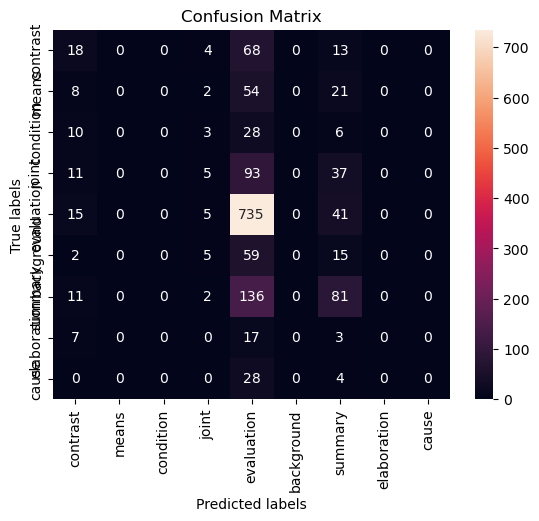

In [34]:
# evaluate and get itemwise results
from sklearn.metrics import confusion_matrix
import seaborn as sns


def cm_plot(y_true, y_pred, rev_label_dict):

  rev_label_dict_list = []
  for i in range(len(rev_label_dict)):
      rev_label_dict_list.append(rev_label_dict[i])
  print(rev_label_dict_list)
  
  ax= plt.subplot()
  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

  ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
  ax.set_title('Confusion Matrix'); 
  ax.xaxis.set_ticklabels(rev_label_dict_list)
  ax.yaxis.set_ticklabels(rev_label_dict_list)
  plt.xticks(rotation=90)


# freeze model weights and measure validation / test 
def evaluate_accuracy_itemwise(model, optimizer, data_loader, rev_label_dict, label_dict, is_training=True):
  model.eval()
  total_val_acc  = 0
  total_val_loss = 0
  
  #for classification report
  y_true = []
  y_pred = []
  idx_list = []
  premise_list = []
  hypo_list = []
  idx_map = mnli_dataset_en.val_idx if is_training else mnli_dataset_en.test_idx

  with torch.no_grad():
    for batch_idx, (pair_token_ids, mask_ids, feat, y, idx) in enumerate(data_loader):      
      optimizer.zero_grad()
      pair_token_ids = pair_token_ids.to(device)
      mask_ids = mask_ids.to(device)
      labels = y.to(device)
      
      outputs = model(pair_token_ids, 
                            attention_mask=mask_ids, 
                            feat=feat)
      criterion = nn.CrossEntropyLoss()
      loss = criterion(outputs, labels)

      # log predictions for classification report
      argmax_predictions = torch.argmax(outputs,dim=1).tolist()
      labels_list = labels.tolist()
      assert(len(labels_list)==len(argmax_predictions))
      for p in argmax_predictions: y_pred.append(rev_label_dict[int(p)])
      for l in labels_list: y_true.append(rev_label_dict[l])
      for i in idx.tolist():
        idx_list.append(i)
        premise_list.append(idx_map[i][0])
        hypo_list.append(idx_map[i][1])

  cm_plot(y_true, y_pred, rev_label_dict)
  return y_true, y_pred

  idx_json = {'idx': idx_list, 'gold_label': y_true, 'pred_label': y_pred, 'premise': premise_list, 'hypothesis': hypo_list}

model.load_state_dict(torch.load('run1/'+save_path_suffix+suffix+'_best_latest.pt'))
y_true, y_pred = evaluate_accuracy_itemwise(model, optimizer, test_loader_en, rev_label_dict_en, label_dict_en, is_training=False)

/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/transformers/modeling_utils.py:768: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


['elaboration', 'contrast', 'elaboration', 'elaboration', 'elaboration', 'background', 'contrast', 'elaboration', 'joint', 'joint', 'elaboration', 'contrast', 'contrast', 'elaboration', 'contrast', 'elaboration', 'joint', 'elaboration', 'elaboration', 'elaboration', 'elaboration', 'joint', 'elaboration', 'joint', 'elaboration', 'joint', 'joint', 'elaboration', 'elaboration', 'elaboration', 'contrast', 'joint', 'elaboration', 'elaboration', 'elaboration', 'joint', 'contrast', 'contrast', 'elaboration', 'joint', 'joint', 'contrast', 'joint', 'joint', 'elaboration', 'elaboration', 'elaboration', 'elaboration', 'elaboration', 'elaboration', 'joint', 'elaboration', 'joint', 'elaboration', 'elaboration', 'elaboration', 'background', 'elaboration', 'contrast', 'elaboration', 'contrast', 'elaboration', 'elaboration', 'elaboration', 'elaboration', 'elaboration', 'elaboration', 'elaboration', 'elaboration', 'contrast', 'elaboration', 'elaboration', 'elaboration', 'contrast', 'elaboration', 'join

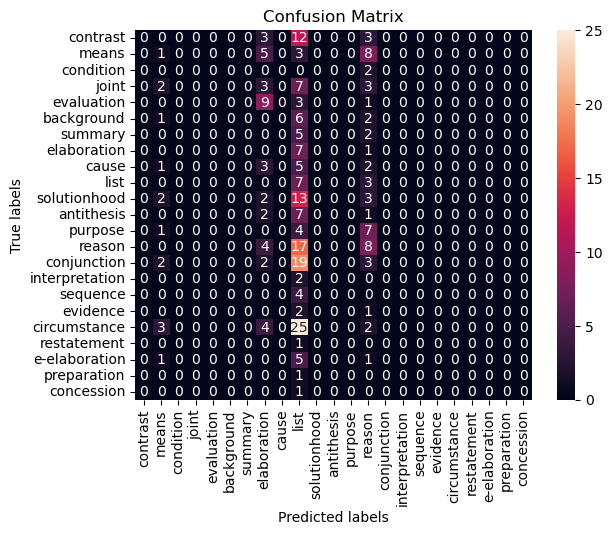

In [38]:
# evaluate and get itemwise results
from sklearn.metrics import confusion_matrix
import seaborn as sns


def cm_plot(y_true, y_pred, rev_label_dict):

  rev_label_dict_list = []
  for i in range(len(rev_label_dict)):
      if rev_label_dict[i] in y_true:
        rev_label_dict_list.append(rev_label_dict[i])
  print(rev_label_dict_list)
  
  ax= plt.subplot()
  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

  ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
  ax.set_title('Confusion Matrix'); 
  ax.xaxis.set_ticklabels(rev_label_dict_list)
  ax.yaxis.set_ticklabels(rev_label_dict_list)
  plt.xticks(rotation=90)


# freeze model weights and measure validation / test 
def evaluate_accuracy_itemwise(model, optimizer, data_loader, rev_label_dict, label_dict, is_training=True):
  model.eval()
  total_val_acc  = 0
  total_val_loss = 0
  
  #for classification report
  y_true = []
  y_pred = []
  idx_list = []
  premise_list = []
  hypo_list = []
  idx_map = mnli_dataset_en.val_idx if is_training else mnli_dataset_en.test_idx

  with torch.no_grad():
    for batch_idx, (pair_token_ids, mask_ids, feat, y, idx) in enumerate(data_loader):      
      optimizer.zero_grad()
      pair_token_ids = pair_token_ids.to(device)
      mask_ids = mask_ids.to(device)
      labels = y.to(device)
      
      outputs = model(pair_token_ids, 
                            attention_mask=mask_ids, 
                            feat=feat)
      criterion = nn.CrossEntropyLoss()
      loss = criterion(outputs, labels)

      # log predictions for classification report
      argmax_predictions = torch.argmax(outputs,dim=1).tolist()
      labels_list = labels.tolist()
      assert(len(labels_list)==len(argmax_predictions))
      for p in argmax_predictions: y_pred.append(rev_label_dict[int(p)])
      for l in labels_list: y_true.append(rev_label_dict[l])
      for i in idx.tolist():
        idx_list.append(i)
        premise_list.append(idx_map[i][0])
        hypo_list.append(idx_map[i][1])

  cm_plot(y_true, y_pred, rev_label_dict)
  return y_true, y_pred

  idx_json = {'idx': idx_list, 'gold_label': y_true, 'pred_label': y_pred, 'premise': premise_list, 'hypothesis': hypo_list}

model.load_state_dict(torch.load('run1/'+save_path_suffix+suffix+'_best_latest.pt'))
y_true, y_pred = evaluate_accuracy_itemwise(model, optimizer, test_loader_de, rev_label_dict_de, label_dict_de, is_training=False)